In [20]:
import gwsurrogate
import numpy as np
import matplotlib.pyplot as plt
import bilby
from gwpy.timeseries import TimeSeries

In [21]:
sur=gwsurrogate.LoadSurrogate('NRSur7dq4')

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:245: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.t = h5file['t_ds'].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:272: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_coefs'%(key)].value,
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:273: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'bfOrders': group['%s_bfOrders'%(key)].value
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/gwsurrogate/new/precessing_surrogate.py:282: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  'coefs': group['%s_%d_coefs'%(key, i)].value,
/Users/zohaggard/anaconda2/envs/igw

Loaded NRSur7dq4 model


In [22]:
def sigmoid(x, x0, L, k):
    
    """ generate a sigmoid to be mult. to damped sinusoid.
        x is time, x0 is the midpoint of the sigmoid, L is the amplitude, and k is the growth 
    """
    
    sig = []
    
    for item in x:
        value=L/(1+np.exp(-k*(item-x0)))
        sig.append(value)
    return sig

In [23]:
def create_bru_values(m_odd, em, M, a, n_ref):
    
    """ 
    m_odd is odd integer, g_s is string coupling (GR == 1), em is 2,
    M is total mass, a is dimensionless spin, and amplitude_qnm is 
    the amplitude of the mode of interest 
    
    returns amplitude (quantum), omega_real, tau, and tp
    
    """
    
    g_s = 1/n_ref
    c = 3e8
    G = 6.67e-11
    Msun = 1.989e30
    
    conversion_w = (c**3)/(G * M * Msun)
    R_con = (2 * G * M * Msun) / (c**2)
    
    r_s = (R_con + np.sqrt((R_con**2) - 4*(a**2)))/2 #units m
    omega_real = (m_odd * np.pi /(2 * r_s * n_ref)) * c   #units 1/m --> 1/s
    omega_im = - (1/r_s) * (1/(n_ref**2)) * c
    
    tau = 1/omega_im
    tp = 1/omega_real 
    
    print("Quantum freq is {}".format(omega_real/(2*np.pi)))
    print("Quantum tau is {}".format(tau))
    print("t_s is {}".format(tp))
    
    return {'omega_real_Q': omega_real, 'omega_img_Q': omega_im,
            'tau_Q': tau, 'tp_Q': tp, 'freq_Q': (omega_real/(2*np.pi))}

In [24]:
def damped_sine_keys(time, amplitude, tau, tp, freq, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h = np.zeros(len(time), dtype=np.complex64)
    tidx = time >= tp
    
    damp_arg = -(time[tidx])/tau
    sin_arg = (2 * np.pi * freq * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
    sig = sigmoid(x=time, x0=(tp*1.5), L=amplitude, k=4096)
    print(h.real*sig/amplitude)
     
    return {'plus': h.real*sig/amplitude, 'cross': h.imag*sig/amplitude}

In [25]:
def damped_sine(time, amplitude, tau, tp, omega_real, phase):
    
    """
    returns damped complex sine as h (type=array) 
    assumes that tau is negative number
    starts a time tp: anytime before is 0

    """
    
    
    h = np.zeros(len(time), dtype=np.complex128)
    tidx = time >= tp
    
    damp_arg = (time[tidx])/tau
    sin_arg = (omega_real * (time[tidx])) - phase
    h[tidx] = amplitude*np.exp(damp_arg) * np.exp((1j*sin_arg)) 
    
    
    return h

In [26]:
def Quantummodes(time, q, chiA, chiB, M, dist_mpc, inclination, a, n_ref, amplitude, phase):
    
    """ 
    model that has NR SUR (for given parameters) and associated quantum mode 
    chiA and chiB take [x,y,x] as input
    assumes dt = 1/4096
    highest l index is ellMax, assumed to be 4
    f_ref=30, and f_low=0
    
    note: NRSUR peak of waveform packet is at t=0
    
          spin=0 for now (need to change em otherwise)
    
    """
    
    #generate NRSUR

    f_ref = 30     
    f_low = 0   
    ellMax = 4  
    
    t, h, dyn = sur(q, chiA, chiB, dt=1/4096, f_low=f_low,
                    ellMax=ellMax, M=M, dist_mpc=dist_mpc, units='mks',
                    inclination=inclination, f_ref=f_ref)
    #h_new
    
    bru_values = create_bru_values(m_odd=1, em=0, M=M, a=a, n_ref=n_ref)
    
    bru_sin = damped_sine(time=time, amplitude=amplitude, 
                       tau=bru_values['tau_Q'], tp=bru_values['tp_Q'], 
                       omega_real=bru_values['omega_real_Q'], phase=phase)
    print(bru_values['tp_Q'])
    sig = sigmoid(x=time, x0=bru_values['tp_Q']*1.5, L=amplitude, k=4096)
    dif = len(bru_sin)-len(h)
    h_new = np.pad(h, (0, dif), 'constant')
    h_total = h_new+(bru_sin*sig/amplitude)
    
    plt.plot(time, h_new.real, label='NRsur')
    plt.plot(time, bru_sin.real, label='unmodified Quantum')
    plt.plot(time, (bru_sin*sig)/amplitude, label='sig mult')
    plt.plot(time, h_total.real, label='total')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.xlim(0,0.1)
    
    print(h_total)
    return {'plus': h_total.real, 'cross': h_total.imag}
    

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


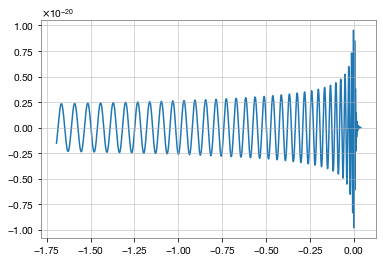

In [27]:
q = 1
chiA = [0,0,0]
chiB = [0,0,0]
M = 80
dist_mpc = 100
ellMax = 4     
inclination = 0
f_low=0
f_ref = 30
dt=1/4096

t, h, dyn = sur(q, chiA, chiB, dt=dt, f_low=f_low, ellMax=ellMax, M=M, dist_mpc=dist_mpc,
               inclination=inclination, units='mks', f_ref=f_ref)
plt.plot(t, h)

In [28]:
injection_parameters = dict(q=1, chiA=[0,0,0], chiB=[0,0,0], M=80, 
                            dist_mpc=100, inclination=0,
                            a=0, n_ref=5, amplitude=5e-21, phase=0,
                            ra=0, dec=0, psi=0, geocent_time=0)

In [29]:
injection_waveform = bilby.gw.waveform_generator.WaveformGenerator(
    time_domain_source_model=Quantummodes,
    duration=2, sampling_frequency=4096,
    start_time=t[0])

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/detector/psd.py:356: RuntimeWarning: invalid value encountered in multiply
  frequency_domain_strain = self.__power_spectral_density_interpolated(frequencies) ** 0.5 * white_noise
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
15:15 bilby INFO    : Injected signal in V1:
15:15 bilby INFO    :   optimal SNR = 196.41
15:15 bilby INFO    :   matched filter SNR = 197.90+1.59j
15:15 bilby INFO    :   q = 1
15:15 bilby INFO    :   chiA = [0, 0, 0]
15:15 bilby INFO    :   chiB = [0, 0, 0]
15:15 bilby INFO    :   M = 80
15:15 bilby INFO    :   dist_mpc =

Quantum freq is 63.59942200845278
Quantum tau is -0.019654266666666663
t_s is 0.0025024589542770154
0.0025024589542770154
[-1.52997519e-21+1.74768391e-21j -1.49388352e-21+1.77691226e-21j
 -1.45769367e-21+1.80600307e-21j ...
 -7.10526757e-28+5.77503580e-28j -7.53976000e-28+4.99307174e-28j
 -7.89162065e-28+4.18263395e-28j]


[{'plus': array([ 1.16825212e-23+0.00000000e+00j,
          1.62639114e-23-9.08443983e-24j,
          2.39342945e-23-1.12852874e-23j, ...,
         -1.88375268e-25+2.08635450e-27j,
         -1.90177369e-25+1.70568199e-27j,
         -1.91002226e-25+0.00000000e+00j]),
  'cross': array([1.93889544e-23+0.00000000e+00j,
         2.08889098e-23+3.39790704e-24j,
         1.83788864e-23+2.54478955e-24j, ...,
         2.12392250e-25+2.83523598e-27j,
         2.09663315e-25+2.40813778e-27j,
         2.08423146e-25+0.00000000e+00j])},
 {'plus': array([ 1.16825212e-23+0.00000000e+00j,
          1.62639114e-23-9.08443983e-24j,
          2.39342945e-23-1.12852874e-23j, ...,
         -1.88375268e-25+2.08635450e-27j,
         -1.90177369e-25+1.70568199e-27j,
         -1.91002226e-25+0.00000000e+00j]),
  'cross': array([1.93889544e-23+0.00000000e+00j,
         2.08889098e-23+3.39790704e-24j,
         1.83788864e-23+2.54478955e-24j, ...,
         2.12392250e-25+2.83523598e-27j,
         2.09663315e-25+2

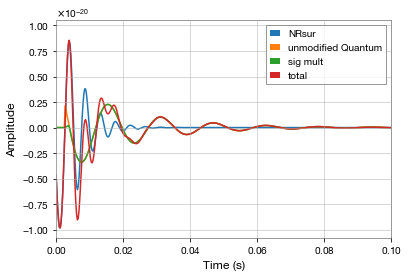

In [30]:
ifos = bilby.gw.detector.InterferometerList(['V1','H1'])
ifos.set_strain_data_from_power_spectral_densities(
    duration=2, sampling_frequency=4096)
ifos.inject_signal(waveform_generator=injection_waveform,
                  parameters=injection_parameters)

In [31]:
prior = {}
prior['amplitude'] = bilby.core.prior.DeltaFunction(5e-21, r'$h_0$')
prior['tp'] = bilby.core.prior.DeltaFunction(0.0025, r'$t_{s}$')
prior['tau'] = bilby.core.prior.LogUniform(1e-3, 1e-1, r'$\tau$', unit='$s$')
prior['freq'] = bilby.core.prior.Uniform(30, 90, r'frequency', unit='Hz')
prior['phase'] = bilby.core.prior.DeltaFunction(0)
prior['ra'] = bilby.core.prior.DeltaFunction(0)
prior['dec'] = bilby.core.prior.DeltaFunction(0)
prior['psi'] = bilby.core.prior.DeltaFunction(0)
prior['geocent_time'] = bilby.core.prior.DeltaFunction(0)

In [32]:
search_waveform = bilby.gw.WaveformGenerator(
    duration=2, sampling_frequency=4096, 
    time_domain_source_model=damped_sine_keys)

In [33]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers=ifos, waveform_generator=search_waveform)

In [34]:
result = bilby.run_sampler(
            likelihood=likelihood, priors=prior, sampler='dynesty', npoints=500, walks=10, 
            nact=5, outdir='/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/n5M80/', #change nref5,40
            label='5e-21_sample=freq_tau',
            resume=False, injection_parameters=dict(
                                                    freq=63,
                                                    tau=0.0196))

15:15 bilby INFO    : Running for label '5e-21_sample=freq_tau', output will be saved to '/Users/zohaggard/Desktop/LIGOSURF/add_quantummode/n5M80/'
15:15 bilby INFO    : Using LAL version Branch: None;Tag: lal-v6.22.0;Id: 38829b72bfb5f26391b9866d286dd77db7942dd1;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
15:15 bilby INFO    : Search parameters:
15:15 bilby INFO    :   tau = LogUniform(minimum=0.001, maximum=0.1, name='$\\tau$', latex_label='$\\tau$', unit='$s$', boundary=None)
15:15 bilby INFO    :   freq = Uniform(minimum=30, maximum=90, name='frequency', latex_label='frequency', unit='Hz', boundary=None)
15:15 bilby INFO    :   amplitude = 5e-21
15:15 bilby INFO    :   tp = 0.0025
15:15 bilby INFO    :   phase = 0
15:15 bilby INFO    :   ra = 0
15:15 bilby INFO    :   dec = 0
15:15 bilby INFO    :   psi = 0
15:15 bilby INFO    :   geocent_time = 0


[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40129846e-43
 1.66754517e-43 1.91977890e-43]
[ 0.  0.  0. ... -0.  0.  0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -2.88798328e-35 -5.28235191e-35 -7.61330555e-35]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -4.55679475e-38  1.64567146e-38  7.76830543e-38]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.46391482e-32
 8.24135269e-32 8.99384599e-32]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.37170481e-31 -5.79907392e-32  2.11179882e-32]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0.  0.  0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -2.69338472e-35 -2.56159131e-35 -2.40483343e-35]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.0000

15:15 bilby INFO    : Single likelihood evaluation took 2.305e-02 s


[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.04175513e-35
 6.67558880e-35 7.22348855e-35]

0it [00:00, ?it/s]

15:15 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': None, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x134cc35d0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
15:15 bilby INFO    : Checkpoint every n_check_point = 30000
15:15 bilby INFO    : Using dynesty version 1.0.1


[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0.  0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.86629521e-35
 5.11151321e-35 5.31921181e-35]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ...  0. -0. -0.]
[ 0.  0.  0. ...  0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.40589248e-37
 1.44299483e-37 1.47333664e-37]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
  5.32344374e-38 -7.68935964e-38 -2.04836451e-37]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
  1.38728548e-43  6.44597294e-44 -1.12103877e-44]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.13919702e-33
 3.85297587e-33 2.55890188e-33]

[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0.  0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.03428842e-30 -9.68197145e-31 -8.91706411e-31]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.44702826e-31
 1.73805045e-31 2.01555739e-31]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -5.27530813e-35 -5.45063644e-35 -5.60537064e-35]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.35617933e-31
 8.98237175e-31 9.53676404e-31]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.34384116e-38 -1.53152533e-38 -1.70044332e-38]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.06613611e-34
 2.35326484e-34 2.62221772e-34]
[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -6.8

[ 0.  0.  0. ... -0. -0. -0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.10194770e-43
 1.73761010e-43 1.35925951e-43]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -2.03569991e-39 -1.40100840e-39 -7.56869327e-40]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.07181978e-41
 2.55232502e-41 3.02176001e-41]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.26381584e-37 -2.14009306e-37 -2.97392282e-37]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -6.88415504e-38 -6.57924371e-38 -6.17283408e-38]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18776548e-32
 1.12944487e-32 1.06804381e-32]
[ 0.  0.  0. ... -0. -0. -0.]
[0.0000000

15:15 bilby INFO    : Using the bilby-implemented rwalk sample method with ACT estimated walks


[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.18898699e-36
 1.15749477e-36 1.11407972e-36]
[ 0.  0.  0. ... -0. -0. -0.]

1it [00:11, 11.93s/it, bound:0 nc:1 ncall:501 eff:0.2% logz-ratio=-23004.12+/-0.17 dlogz:inf>0.10][0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]

6it [00:12,  8.36s/it, bound:0 nc:1 ncall:506 eff:1.2% logz-ratio=-20741.45+/-0.17 dlogz:20800.963>0.10][0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.37361410e-36
 1.51621516e-36 1.63515038e-36]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]

10it [00:12,  5.86s/it, bound:0 nc:1 ncall:510 eff:2.0% logz-ratio=-19114.37+/-0.17 dlogz:19345.256>0.10][ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.26116862e-44 -1.40129846e-44 -1.40129

[0. 0. 0. ... 0. 0. 0.]

123it [00:15, 39.47it/s, bound:0 nc:1 ncall:629 eff:19.6% logz-ratio=-5253.67+/-0.17 dlogz:5278.735>0.10][0. 0. 0. ... 0. 0. 0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -3.36827309e-40 -4.45765653e-40 -5.47895088e-40]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -1.50694633e-30 -1.58948428e-30 -1.66140892e-30]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.56097666e-36
 2.69790751e-36 2.81239248e-36]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...
 -2.94272678e-44 -2.80259693e-44 -2.66246708e-44]

128it [00:15, 34.55it/s, bound:0 nc:3 ncall:637 eff:20.1% logz-ratio=-4909.06+/-0.17 dlogz:4971.291>0.10][ 0.  0.  0. ... -0. -0. -0.]
[0. 0. 0. ... 0. 0. 0.]
[ 0.  0.  0. ... -0. -0. -0.]
[ 0.  0.  0. ... -0.  0.  0.]
[0. 0. 0. ... 0. 0. 0.]

133it [00:15, 36.38it/s, bound:0 nc:1 ncall:642 eff:20.7% logz-ratio=-4664.42+/-0.17 dlogz:4682.490>0.10][0. 0.

15:15 bilby WARNING : Run terminated with signal 2
15:15 bilby INFO    : Writing checkpoint file /Users/zohaggard/Desktop/LIGOSURF/add_quantummode/n5M80//5e-21_sample=freq_tau_resume.pickle


[0. 0. 0. ... 0. 0. 0.]

Exception while calling loglikelihood function:
  params: [1.79499757e-03 4.46070682e+01]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/dynesty/dynesty.py", line 939, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/sampler/base_sampler.py", line 591, in log_likelihood
    return Sampler.log_likelihood(self, theta)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/core/sampler/base_sampler.py", line 389, in log_likelihood
    return self.likelihood.log_likelihood_ratio()
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/likelihood.py", line 247, in log_likelihood_ratio
    self.waveform_generator.frequency_domain_strain(self.parameters)
  File "/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/bilby/gw/waveform_generator.py", line 119, in frequency_domain_strain
    transformed_model_data_points=self.time_array)
  Fil

SystemExit: 130

/Users/zohaggard/anaconda2/envs/igwn-py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



138it [00:29, 31.88it/s, bound:0 nc:2 ncall:651 eff:21.2% logz-ratio=-4292.42+/-0.17 dlogz:4317.157>0.10]

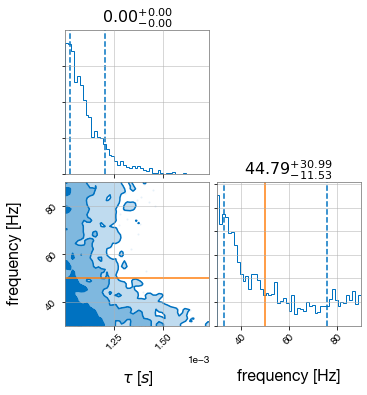

In [469]:
result.plot_corner()